# Is it a bird? Creating a model from your own data
----

Sifiso Rimana | Practical Deep Learning Lecture 1 

In [1]:
from ddgs import DDGS # DuckDuckGo has renamed their package from 'duckduckgo_search' to 'ddgs'
from fastcore.all import *
import time 
import json
from fastdownload import download_url
from fastai.vision.all import *

In [6]:
def search_images(keywords, max_images=200):
    return L(DDGS().images(query=keywords, max_results=max_images)).itemgot("image")

urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/2137850/pexels-photo-2137850.jpeg?cs=srgb&dl=animal-animal-photography-beautiful-2137850.jpg&fm=jpg'

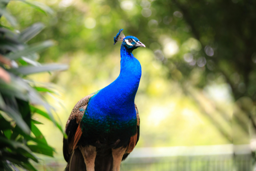

In [ ]:
dest = 'bird.jpg'
download_url(url=urls[0], dest=dest, show_progress=True)

# open the image once it's done downloading
image = Image.open(dest)
image.to_thumb(256, 256)


In [3]:
search_images('forest photos', max_images=1)

(#1) ['https://wallpaperaccess.com/full/2428648.jpg']

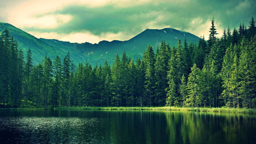

In [5]:
download_url(search_images('forest', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

## Train the model

In [9]:
# first we get the dataset

searchs = 'forest', 'bird'

path = Path('bird_or_not')

for o in searchs:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)

    max_attempts = 10
    attempts = 0
    while attempts < max_attempts:
        try:
            download_images(dest, urls=search_images(f"{o} photo"))
            break
        except Exception as err:
            print(err)
            attempts = attempts + 1
            print("Current attempt:", attempts)
            if attempts == max_attempts:
                print("Max attempts exceeded...")
    time.sleep(5)
    resize_images(path/o, max_size=500, dest=path/o)

In [10]:
# some photos may have faild in the download time, so we unlink them
failed_images = verify_images(get_image_files(path))
failed_images.map(Path.unlink)
len(failed_images)

6

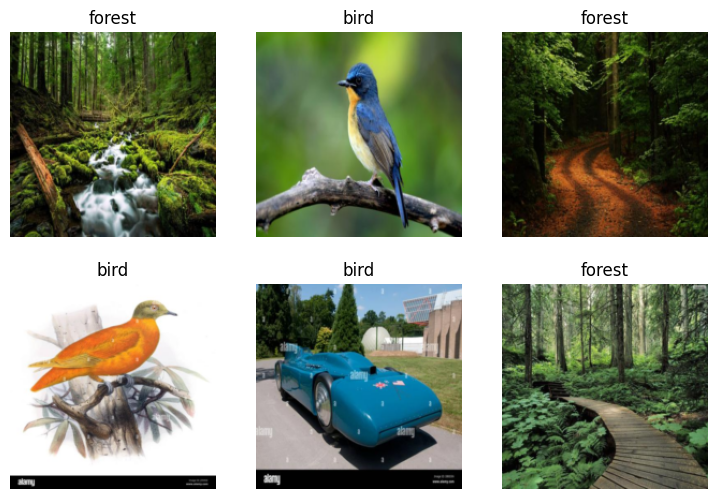

In [12]:
dataloaders = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method="squish")]
).dataloaders(path, bs=32)

dataloaders.show_batch(max_n=6)

In [13]:
# now train the model...

model = vision_learner(dataloaders, resnet18, metrics=error_rate)

model.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\LENOVO/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [01:22<00:00, 567kB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.102695,1.027463,0.361111,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.363568,0.108652,0.055556,00:10
1,0.232669,0.005717,0.000000,00:11
2,0.164262,0.002348,0.000000,00:14
3,0.125056,0.002408,0.000000,00:13
4,0.104787,0.002794,0.000000,00:12


In [14]:
is_bird,_,probs = model.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9988
